In [2]:
import pyterrier as pt
if not pt.started():
    pt.init()
import warnings
warnings.filterwarnings('ignore')
from ir_measures import AP, nDCG, P, R, RR, MRR
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
import numpy as np
import os
import shutil

# work_name="retrievability-bias"
nfs_dir = f'/nfs/datasets/cxj/bm25'
if not os.path.exists(nfs_dir):
    os.makedirs(nfs_dir)

dataset_name = 'msmarco-passage'
# eval_ds_name = 'trec-dl-2019'
eval_ds_name = 'dev'
text_field= 'text'
ranker = "BM25"
retrieve_num = 10
dataset = pt.get_dataset(f'irds:{dataset_name}')
eval_dataset = pt.get_dataset(f'irds:{dataset_name}/{eval_ds_name}')
topics = eval_dataset.get_topics()
qrels = eval_dataset.get_qrels()

# dataset_index = f'/nfs/llm/indices/{dataset_name}'
# index = pt.IndexRef.of(f'{dataset_index}')
index = pt.IndexFactory.of(f'/nfs/llm/indices/{dataset_name}/data.properties')
print(index.getCollectionStatistics())

PyTerrier 0.10.0 has loaded Terrier 5.10 (built by craigm on 2024-08-22 17:33) and terrier-helper 0.0.8



Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



In [3]:
df = pd.DataFrame(dataset.get_corpus_iter(verbose=True))

msmarco-passage documents: 100%|██████████| 8841823/8841823 [00:39<00:00, 225614.01it/s]


In [4]:
df['len'] = df['text'].apply(lambda x: len(x))

In [8]:
df.sort_values(by='len', ascending=False,inplace=True)

In [13]:
import sys
sys.getsizeof(df[df['len']==1665]['text'])

3452

In [14]:
sys.getsizeof(4)

28

In [ ]:
if os.path.exists('./df_msmarco.csv'):
    df = pd.read_csv('./df_msmarco.csv')
else:
    df = pd.DataFrame(dataset.get_corpus_iter(verbose=True))
    df.to_csv('./df_msmarco.csv', index=True)



In [ ]:
# sample_docs = df[text_field].sample(n=1000,random_state=1)
sample_df = df.sample(n=1000000,random_state=1) # 1 M
print(sample_df[0:5])

In [ ]:
def is_number(s):
    try:  
        float(s)
        return True
    except ValueError:  
        pass  
    try:
        import unicodedata  
        unicodedata.numeric(s)  
        return True
    except (TypeError, ValueError):
        pass
    return False

In [ ]:
di = index.getDirectIndex()
doi = index.getDocumentIndex()
lex = index.getLexicon()

In [ ]:
Q = []
terms = []
count=0
for docid, _ in sample_df.iterrows():
    # print(docid)
    # print(f'terms={terms}')
    for posting in di.getPostings(doi.getDocumentEntry(docid)):
        termid = posting.getId()
        lee = lex.getLexiconEntry(termid)
        term = lee.getKey()
        freq = posting.getFrequency()
        if freq >=2 and not is_number(term):
            # print("%s with frequency %d" % (term,freq))
            terms.append(term)
            if len(terms) == 3:
                Q.append(' '.join(terms))
                terms = []
    
    terms = []
    # count +=1
    # if count ==8:
    #     break

In [ ]:
print(f'Q={len(Q)}')

In [ ]:
Q[:10]

In [ ]:
df_Q = pd.DataFrame({'qid':range(0,len(Q)),'query':Q})

In [ ]:
df_Q.shape

In [ ]:
# df_Q.to_csv('./df_Q.csv')
df_Q = pd.read_csv('./df_Q.csv')

In [ ]:
df_Q[:10]

In [ ]:
# tf_idf = pt.terrier.Retriever(index, wmodel="TF_IDF")
bm25 = pt.terrier.Retriever(index, wmodel="BM25") % 10

In [ ]:
# pipe = bm25 >> pt.text.get_text(dataset,'text')

In [ ]:
sample_Q = df_Q.sample(n=1000,random_state=1)

In [ ]:
result = bm25.transform(sample_Q)

In [ ]:
# result[result['docid']==5628017]

In [ ]:
g = result.groupby(['docid'])['docid'].count()

In [ ]:
type(g)

In [ ]:
df_g = pd.DataFrame(g)

In [ ]:
df_g.index.name='inx'

In [ ]:
df_g.shape

In [ ]:
df_g.sort_values(by='docid',inplace=True)

In [ ]:
df_g.loc[5628017]['docid']

In [ ]:
df_sorted = pd.read_csv('./df_sorted.csv')

In [ ]:
df_sorted.shape

In [ ]:
df_sorted = df_sorted.rename(columns = {'docid':'count'})

In [ ]:
df_sorted[:10]
# df_sorted.to_csv('./df_sorted.csv')

In [ ]:
df_sorted = df_sorted[:820000]

In [20]:
df_sorted.shape

(820000, 2)

In [ ]:
df_sorted[:2]['count'].sum()

In [26]:
total = df_sorted['count'].sum()
total

954787

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.pyplot import FixedLocator
import matplotlib as mpl
from matplotlib import cycler
from matplotlib import cm

In [ ]:
x_num = df_sorted.shape[0] + 10000
x0 = [i for i in range(0,x_num,10000)]
equality_scores = [1 for i in range(0,x_num,1)]
y0 = [sum(equality_scores[:i])/df_sorted.shape[0] for i in x0]

In [22]:
x0[-2:]

[810000, 820000]

In [ ]:
equality_scores

In [23]:
y0[-2:]

[0.9878048780487805, 1.0]

In [ ]:
x = [i for i in range(0,x_num,10000)]
y = [df_sorted[0:i]['count'].sum()/total for i in x]

In [24]:
x[-2:]

[810000, 820000]

In [25]:
y[-2:]

[0.9592411710674736, 1.0]

In [ ]:
# df_sorted_tfidf = pd.read_csv('./df_sorted_tfidf.csv')
# df_sorted_tfidf = df_sorted_tfidf[:820000]
# total2 = df_sorted_tfidf['docid'].sum()
# total2

In [ ]:
# x2 = [i for i in range(0,x_num,10000)]
# y2 = [df_sorted_tfidf[0:i]['docid'].sum()/total2 for i in x2]

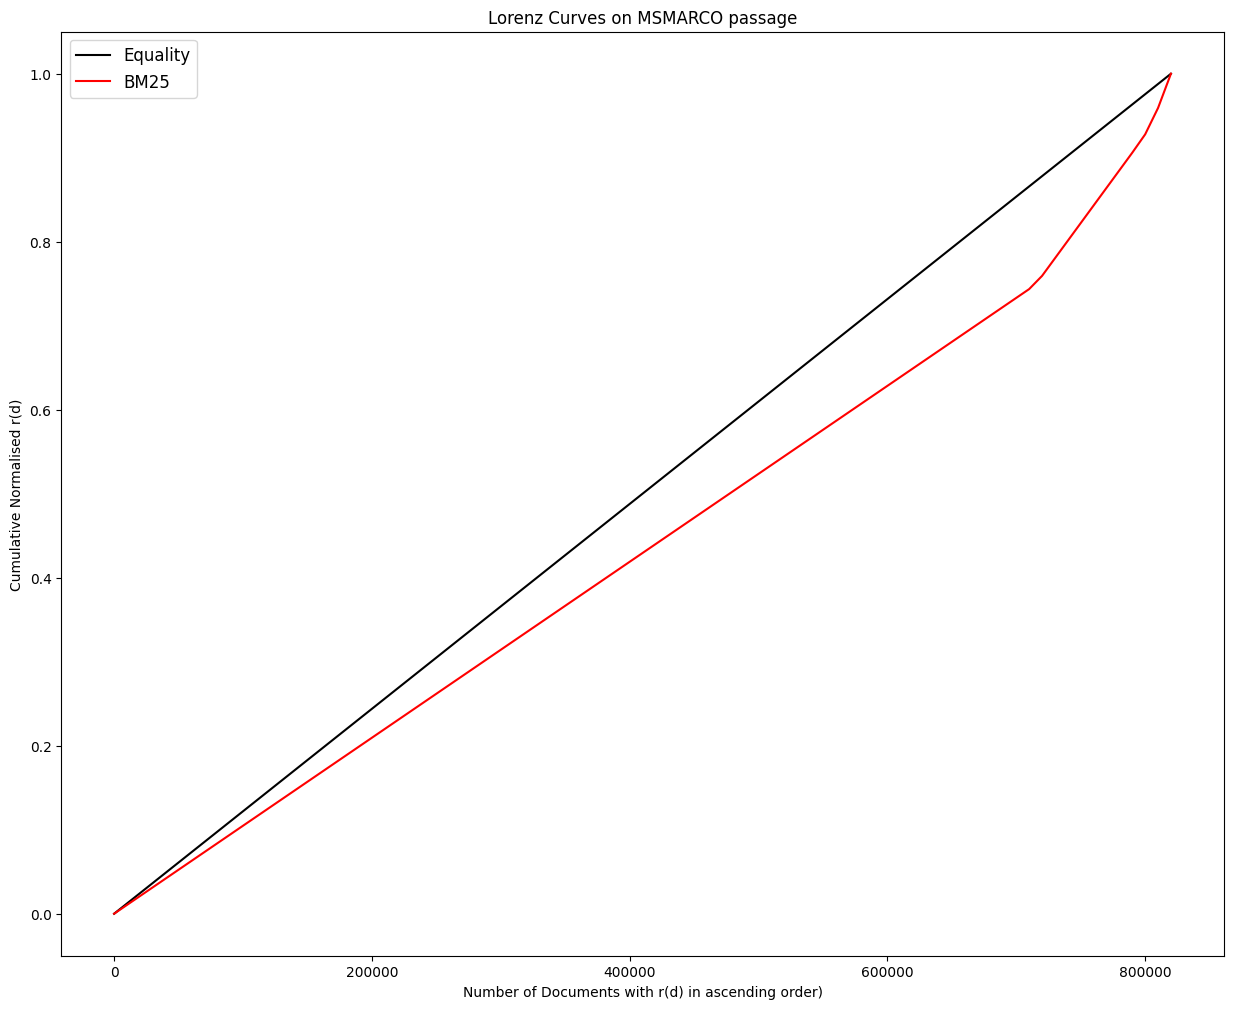

In [21]:
fig1,ax = plt.subplots(1,1, figsize=(15,12))
# plt.xscale('log')
ax.plot(x0,y0,color='black', linestyle='solid', marker='None', label='Equality')
ax.plot(x,y,color='red', linestyle='solid', marker='None', label='BM25')
# ax.plot(x2,y2,color='blue', linestyle='solid', marker='None', label='TF-IDF')

ax.set_title('Lorenz Curves on MSMARCO passage')
ax.set_xlabel('Number of Documents with r(d) in ascending order)')
ax.set_ylabel('Cumulative Normalised r(d)')

ax.legend(prop = {'size':12})

plt.show()